In [73]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_absolute_percentage_error

from sklearn.impute import KNNImputer

In [74]:
data_folder = "data"
filename = "train.csv"
df = pd.read_csv(os.path.join("..", data_folder, filename), parse_dates=True, index_col="date")

### Make it an univariate timeseries

In [75]:
df_subset = df[["warehouse", "orders"]]
df_subset.head()

,warehouse,orders
date,,
2020-12-05,Prague_1,6895.0
2020-12-06,Prague_1,6584.0
2020-12-07,Prague_1,7030.0
2020-12-08,Prague_1,6550.0
2020-12-09,Prague_1,6910.0


In [76]:
Prague_1_test = df_subset[df_subset["warehouse"] == "Prague_1"].drop(columns=["warehouse"])

In [77]:
Prague_1_test.shape

(1193, 1)

In [78]:
def fill_missing_dates_and_values(df):
    """
    Look for missing dates and impute all values
    """
    # Ensure the DataFrame has a continuous date range index
    date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    df = df.reindex(date_range)

    # Impute the missing dates
    imputer = KNNImputer(n_neighbors=2)
    imputed_data = imputer.fit_transform(df)

    # Create a DataFrame with the imputed data
    imputed_df = pd.DataFrame(data=imputed_data, columns=df.columns, index=df.index)

    return imputed_df

Prague_1_full_date_range = fill_missing_dates_and_values(Prague_1_test)
Prague_1_full_date_range.shape

(1197, 1)

In [79]:
Prague_1_full_date_range.reset_index(inplace=True)

### Prophet

In [80]:
# Rename columns
Prague_1_full_date_range.rename(columns={"index": "ds",
                              "orders": "y"}, inplace=True)
Prague_1_full_date_range

,ds,y
0,2020-12-05,6895.0
1,2020-12-06,6584.0
2,2020-12-07,7030.0
3,2020-12-08,6550.0
4,2020-12-09,6910.0
...,...,...
1192,2024-03-11,9866.0
1193,2024-03-12,9710.0
1194,2024-03-13,9628.0
1195,2024-03-14,10056.0


In [81]:
model = Prophet(weekly_seasonality=True, yearly_seasonality=True)

model.fit(Prague_1_full_date_range)


12:11:13 - cmdstanpy - INFO - Chain [1] start processing
12:11:13 - cmdstanpy - INFO - Chain [1] done processing


In [82]:
future = model.make_future_dataframe(periods=365)

forecast = model.predict(future)

/home/marcel/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/marcel/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


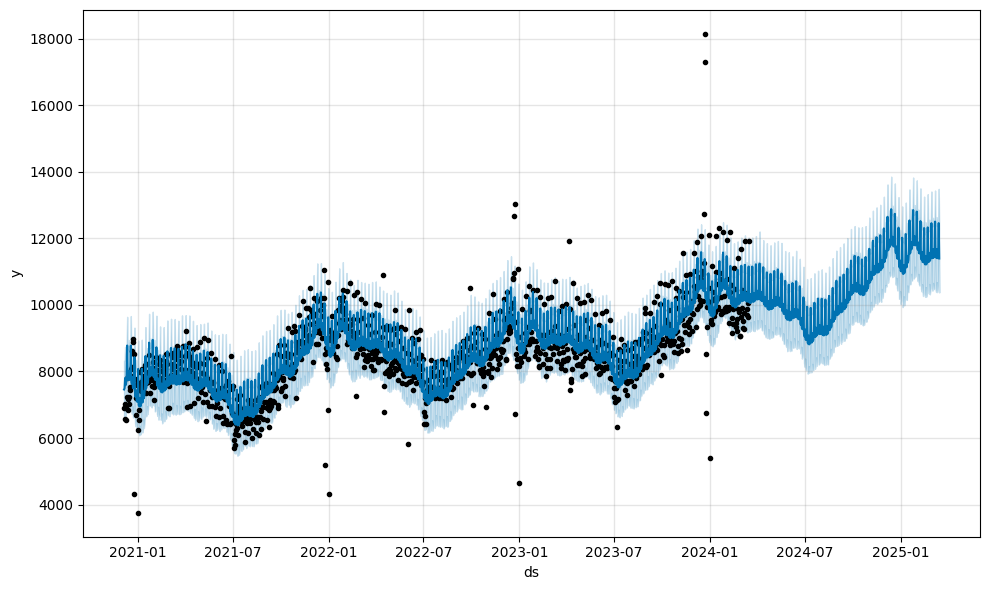

In [83]:
fig1 = model.plot(forecast)
plt.show()

## Test again with validation set

In [84]:
# Take the last year as validation data, as it has a yearly seasonality
split_time = len(Prague_1_full_date_range) - 365

In [85]:
Prague_1_full_date_range_train = Prague_1_full_date_range.iloc[:split_time, :]
Prague_1_full_date_range_val = Prague_1_full_date_range.iloc[split_time:, :]
print(len(Prague_1_full_date_range_train))
print(len(Prague_1_full_date_range_val))

832
365


### Important Holidays

In [92]:
# pre_christmas = pd.DataFrame({
#   'holiday': 'Christmas',
#   'ds': pd.to_datetime(['2021-12-23',
#                         '2022-12-23',
#                         '2023-12-23',
#                         '2024-12-23',]
#                        ),
#   'lower_window': 0,
#   'upper_window': 4,
# })

# new_year = pd.DataFrame({
#   'holiday': 'new_year',
#   'ds': pd.to_datetime(['2021-01-01',
#                         '2022-01-01',
#                         '2023-01-01',
#                         '2024-01-01',]
#                        ),
#   'lower_window': 0,
#   'upper_window': 1,
# })
# holidays = pd.concat((pre_christmas, new_year))

12:12:53 - cmdstanpy - INFO - Chain [1] start processing
12:12:53 - cmdstanpy - INFO - Chain [1] done processing
/home/marcel/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/marcel/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


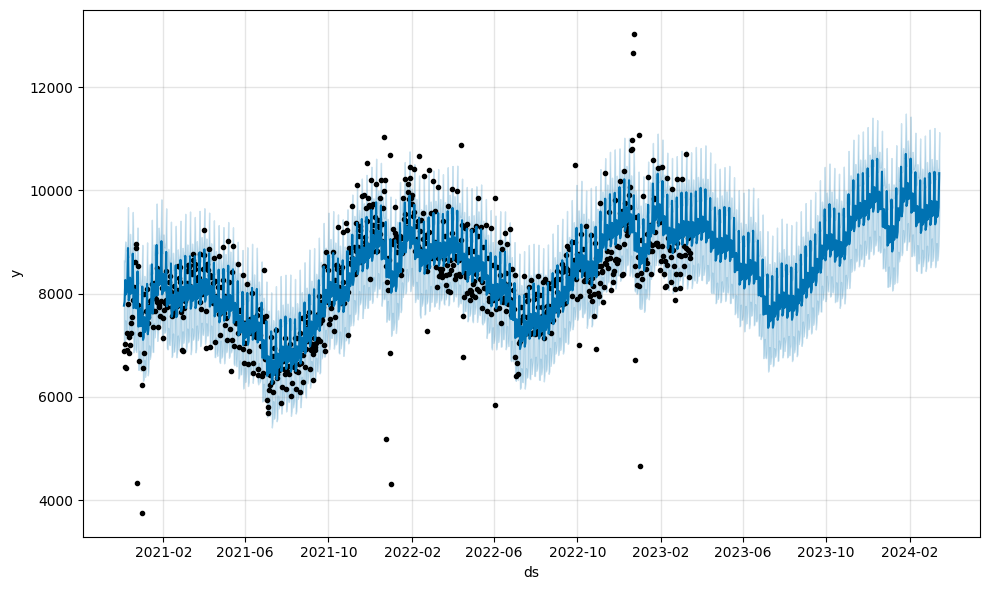

6.17097228253043

In [94]:
model_1 = Prophet(daily_seasonality=True,
                  weekly_seasonality=True,
                  yearly_seasonality=True,
                  changepoint_prior_scale = 0.004,
                  seasonality_prior_scale = 0.2)#,
                  #holidays=holidays)

# model_1.add_country_holidays(country_name='CZ')

model_1.fit(Prague_1_full_date_range_train)

future = model_1.make_future_dataframe(periods=365)

forecast = model_1.predict(future)

fig1 = model_1.plot(forecast)
plt.show()

mean_absolute_percentage_error(Prague_1_full_date_range_val["y"], forecast["yhat"].iloc[split_time:]) * 100

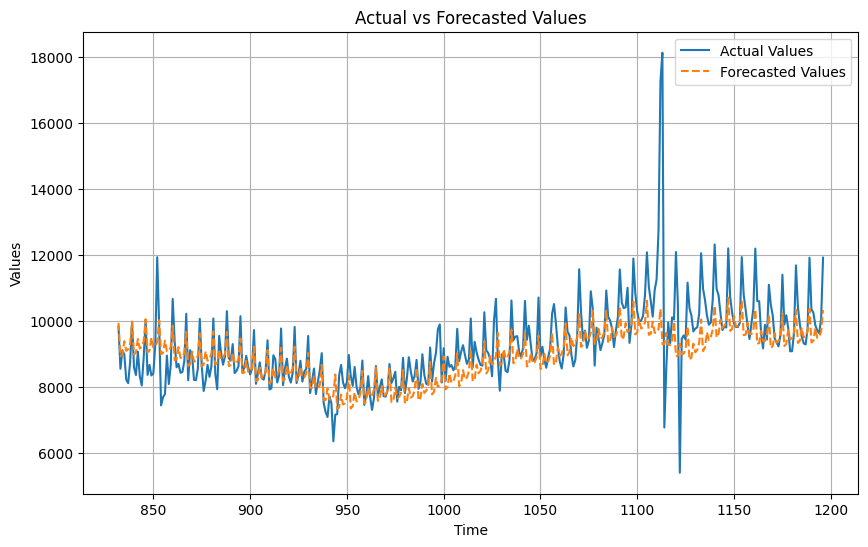

In [88]:
# y Werte für den Plot
y_values = Prague_1_full_date_range_val["y"]
yhat_values = forecast["yhat"].iloc[split_time:]

# Plot erstellen
plt.figure(figsize=(10, 6))
plt.plot(y_values, label='Actual Values')
plt.plot(yhat_values, label='Forecasted Values', linestyle='--')

# Plot-Details
plt.title('Actual vs Forecasted Values')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

# Plot anzeigen
plt.show()

### Where are the high peaks ?

In [89]:

Prague_1_full_date_range_val.loc[Prague_1_full_date_range_val["y"].idxmax(), :]

ds    2023-12-23 00:00:00
y                 18139.0
Name: 1113, dtype: object

### Christmas !!

## TODO Hyperparameter tuning

In [90]:
# # Python
# import itertools
# import numpy as np
# import pandas as pd

# param_grid = {
#     'changepoint_prior_scale': [0.003, 0.004, 0.005, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params).fit(df)  # Fit model with given params
#     df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)